## Job-Shop Scheduling Problem

This notebook demonstrates how to model and solve the classical Job-Shop Scheduling Problem 
using Constraint Programming with IBM’s CP Optimizer via the [`docplex.cp`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/refman.html) Python API.


### Problem Definition

$$
\begin{aligned}
\min \quad & \max_{i \in [1..N]} \text{endOf}(x_{iM}) \quad & \quad & \text{(1)} \\
\text{s.t.} \quad
& \text{noOverlap}([x_{ij}]_{i,j \in [1..N]\times[1..M]: MC_{ij}=k}), \quad & \forall k \in [1..M] \quad & \text{(2)} \\
& \text{endBeforeStart}(x_{i,j-1}, x_{ij}), \quad & \forall i \in [1..N],\ j \in [2..M] \quad & \text{(3)} \\
& \text{interval } x_{ij},\ \text{size} = PT_{ij}, \quad & \forall i \in [1..N],\ j \in [1..M] \quad & \text{(4)}
\end{aligned}
$$

We are given:

- A finite set of **jobs** indexed by $i \in [1..N]$
- A finite set of **machines** indexed by $k \in [1..M]$

Each job $i$ consists of a predefined sequence of **operations**: $ x_{i1},\ x_{i2},\ \dots,\ x_{iM} $

Each operation $x_{ij}$:
- must be processed on a **specific machine** $MC_{ij}$,
- requires a **known processing time** $PT_{ij} > 0$, and
- must be executed **after** the previous operation of the same job has completed.

At any given time, each machine can process **at most one operation**.  
The goal is to determine **start times** and **machine assignments** for all operations  
such that:
- The order of operations within each job is respected (3).
- No two operations processed on the same machine overlap in time (2).
- The **makespan** $C_{\max}$ — the completion time of the last finishing job — is **minimized** (1).

#### Symbols and Notation

| Symbol / Function | Meaning | docplex.cp reference |
|---|---|---|
| $N$ | Number of jobs | — |
| $M$ | Number of machines | — |
| $i$ | Job index ($i \in [1..N]$) | — |
| $j$ | Operation index within a job ($j \in [1..M]$) | — |
| $k$ | Machine index ($k \in [1..M]$) | — |
| $x_{ij}$ | Interval variable representing operation $j$ of job $i$ | — |
| $\text{endOf}(x_{ij})$ | End time of operation $x_{ij}$ (mathematical notation) | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) |
| $MC_{ij}$ | Machine assigned to operation $x_{ij}$ | — |
| $PT_{ij}$ | Processing time (duration) of operation $x_{ij}$ | — |
| $\text{noOverlap}(\cdot)$ | Ensures that operations using the same machine do not overlap in time | [docplex.cp.modeler.no_overlap](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.no_overlap) |
| $\text{endBeforeStart}(x_{i,j-1}, x_{ij})$ | Enforces operation $j$ starts after operation $j-1$ of the same job finishes | [docplex.cp.modeler.end_before_start](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_before_start) |
| $\text{interval } x_{ij}, \text{ size}=PT_{ij}$ | Declares $x_{ij}$ as an interval variable with duration $PT_{ij}$ | [docplex.cp.expression.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html#docplex.cp.expression.interval_var) |
| $\max_{i \in [1..N]} \text{endOf}(x_{iM})$ | Represents the makespan (the time when the last job finishes) | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) |
| $C_{\max}$ | Overall completion time (makespan) of the schedule | — |
| $\min C_{\max}$ | Objective: minimize makespan | [docplex.cp.modeler.minimize](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.minimize) |


### Implementation

  > This notebook is an adaptation of the *Jobshop-basic* example from the  
> [IBM Decision Optimization CPLEX Modeling for Python (DOcplex) Examples Repository](https://github.com/IBMDecisionOptimization/docplex-examples/tree/master).  

#### Imports

In [1]:
from docplex.cp.model import *

# Needed only for visualisation
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt

#### Reading the data file

In [2]:
filename = "../data/jobshop/jobshop_ft06.data"

# Available files are jobshop_ft06, jobshop_ft10 and jobshop_ft20
# First line contains the number of jobs, and the number of machines.
# The rest of the file consists of one line per job.
# Each line contains list of operations, each one given by 2 numbers: machine and duration
with open(filename, "r") as f:
    N, M = map(int, f.readline().split()) # N (jobs), M (machines)
    MC = []  # MC[i][j] = machine for operation j of job i
    PT = []  # PT[i][j] = processing time for operation j of job i
    
    # For each job line: read M pairs (machine, duration)
    for _ in range(N):
        values = [int(v) for v in f.readline().split()]
        MACHINES = [values[2*j] for j in range(M)]
        DURATIONS = [values[2*j + 1] for j in range(M)]
        MC.append(MACHINES)
        PT.append(DURATIONS)

In [3]:
# Quick check of the parsed data
print(f"Number of jobs (N): {N}")
print(f"Number of machines (M): {M}\n")

for i in range(N):
    print(f"Job {i}:")
    for j in range(M):
        print(f"  Operation x[{i},{j}] → Machine {MC[i][j]}, Duration {PT[i][j]}")

Number of jobs (N): 6
Number of machines (M): 6

Job 0:
  Operation x[0,0] → Machine 2, Duration 1
  Operation x[0,1] → Machine 0, Duration 3
  Operation x[0,2] → Machine 1, Duration 6
  Operation x[0,3] → Machine 3, Duration 7
  Operation x[0,4] → Machine 5, Duration 3
  Operation x[0,5] → Machine 4, Duration 6
Job 1:
  Operation x[1,0] → Machine 1, Duration 8
  Operation x[1,1] → Machine 2, Duration 5
  Operation x[1,2] → Machine 4, Duration 10
  Operation x[1,3] → Machine 5, Duration 10
  Operation x[1,4] → Machine 0, Duration 10
  Operation x[1,5] → Machine 3, Duration 4
Job 2:
  Operation x[2,0] → Machine 2, Duration 5
  Operation x[2,1] → Machine 3, Duration 4
  Operation x[2,2] → Machine 5, Duration 8
  Operation x[2,3] → Machine 0, Duration 9
  Operation x[2,4] → Machine 1, Duration 1
  Operation x[2,5] → Machine 4, Duration 7
Job 3:
  Operation x[3,0] → Machine 1, Duration 5
  Operation x[3,1] → Machine 0, Duration 5
  Operation x[3,2] → Machine 2, Duration 5
  Operation x[3,3

#### Create model and variables

In [4]:
# Create a CP Optimizer model
mdl = CpoModel()

# Define interval variables for each operation x_ij with duration PT_ij (4)
x = [
    [interval_var(size=PT[i][j], name=f"x_{i}_{j}") for j in range(M)]
    for i in range(N)
]

# Group operations by machine for later use in noOverlap constraints
# machine_ops[k] will hold all interval variables x[i][j] that are processed
# on machine k.
machine_operations = [[] for _ in range(M)]
for i in range(N):
    for j in range(M):
        k = MC[i][j] # machine assigned to operation x[i][j]
        machine_operations[k].append(x[i][j])

#### Add constraints and define objective

In [5]:
# (3) Technological order: each operation j of job i starts after operation j-1 ends
mdl.add([end_before_start(x[i][j-1], x[i][j]) for i in range(N) for j in range(1, M)])

# (2) Machine capacity: each machine can process only one operation at a time
mdl.add([no_overlap(machine_operations[k]) for k in range(M)])

# (1) Objective: minimize makespan = max_i endOf(last op of job i)
mdl.add(minimize(mdl.max(end_of(x[i][M-1]) for i in range(N))))

#### Solve the model

In [8]:
print('Solving model...')
res = mdl.solve(TimeLimit=10)
print('Solution:')
res.print_solution()

Solving model...
 ! --------------------------------------------------- CP Optimizer 22.1.2.0 --
 ! Minimization problem - 42 variables, 36 constraints
 ! TimeLimit            = 10
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 186.1 (before), 186.1 (after)


 !  . Memory usage      : 510.4 kB (before), 510.4 kB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         42                 -
 + New bound is 47
 ! Using iterative diving.
 *            65       73  0.03s        1      (gap is 27.69%)
 *            64      145  0.03s        1      (gap is 26.56%)
 *            62      217  0.03s        1      (gap is 24.19%)
 *            61      289  0.03s        1      (gap is 22.95%)
 *            60      361  0.03s        1      (gap is 21.67%)
 *            59      441  0.03s        1      (gap is 20.34%)
 *            58      509  0.03s        1      (gap is 18.97%)
 *            57      540  0.03s        1      (gap is 17.54%)
 *            56      587  0.03s        1      (gap is 16.07%)
 *            55      618  0.03s        1      (gap is 14.55%)
              55     

#### Visualisation

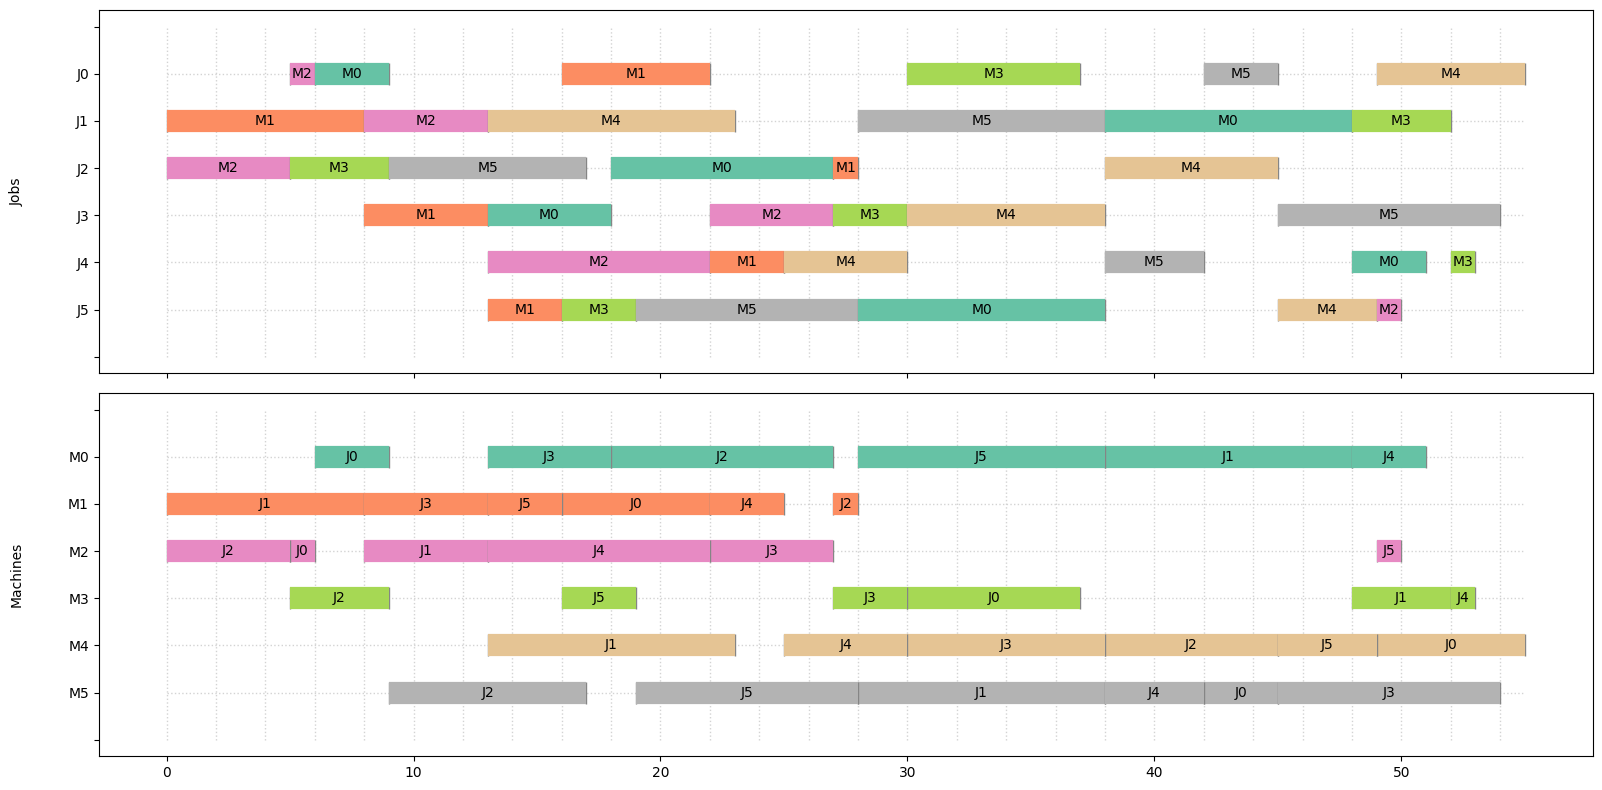

In [7]:
if res and res.is_solution() and visu.is_visu_enabled():
    plt.rcParams["figure.figsize"] = (16, 8)
    visu.panel('Jobs')
    for i in range(N):
        visu.sequence(
            name=f'J{i}',
            intervals=[(res.get_var_solution(x[i][j]), MC[i]
                        [j], f'M{MC[i][j]}') for j in range(M)]
        )
    visu.panel('Machines')
    for k in range(M):
        intervals = []
        for i in range(N):
            for j in range(M):
                if MC[i][j] == k:
                    intervals.append(
                        (res.get_var_solution(x[i][j]), k, f'J{i}'))
        visu.sequence(name=f'M{k}', intervals=intervals)

    visu.show()

### Additional Resources

- **IBM DOcplex CP – Job Shop Basic**
  - https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/visu/job_shop_basic.py

- **IBM DOcplex CP – Flexible Job Shop**
  - https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/visu/job_shop_flexible.py
  - Flexible JSSP where operations can choose among alternative machines (routing decisions).

- **IBM DOcplex CP – Stochastic Job Shop**
  - https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/visu/job_shop_stochastic.py
  - Models uncertainty (e.g., durations) with scenario-based or stochastic constructs.
  
- **Hoorn, J. J. van (2018). _The current state of bounds on benchmark instances of the job-shop scheduling problem._**  
  *Journal of Scheduling, 21*(1), 127–128.  
  [https://link.springer.com/article/10.1007/s10951-017-0547-8](https://link.springer.com/article/10.1007/s10951-017-0547-8)

- **Kaggle – 10,000 Job-Shop Problem Instances**
  - https://www.kaggle.com/datasets/yidalin/10000jobshop-problem-data
  - Large repository of JSSP instances for benchmarking